# Simulation of $Z_2$ gauge theory including readout-error mitigation

## Import modules Save copy in github

---



In [ ]:
#Standard modules
from math import pi
import numpy as np
from numpy import sum
import matplotlib.pyplot as plt

#Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.tools.monitor import job_monitor 
from qiskit.providers.ibmq import RunnerResult
#from qiskit import *
#from qiskit.visualization import *
#from qiskit.visualization import plot_histogram
#TEST


## Load IBM-Q account

In [ ]:
#loading account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
backend = provider.get_backend('ibmq_belem')
program = provider.runtime.program('circuit-runner')

ibmqfactory.load_account:WARNING:2022-02-22 19:09:00,390: Credentials are already in use. The existing account in the session will be replaced.


## Define functions

In [ ]:
def gauge_kinetic(epsilon):
    circuit=QuantumCircuit(1)
    circuit.rx(-epsilon/2,0)
    U_kg = circuit.to_gate()
    U_kg.name = "U$_{Kg}$"
    return U_kg

def fermion_mass(epsilon,mass,eta):
    circuit=QuantumCircuit(1)
    circuit.rz(-epsilon*mass * eta,0)
    U_m = circuit.to_gate()
    U_m.name = "U$_m$"
    return U_m

def fermion_hopping_opt2(epsilon,eta):
    circuit= QuantumCircuit(3)
    circuit.cx(0,2)
    circuit.h(0)
    circuit.cx(1,0)
    circuit.cx(0,2)
    circuit.rz(epsilon/4 * eta,0)
    circuit.rz(-epsilon/4 * eta,2)
    circuit.cx(0,2)
    circuit.cx(1,0)
    circuit.h(0)
    circuit.cx(0,2)
    U_fho2 = circuit.to_gate()
    U_fho2.name = "U$_{fho2}$"
    return U_fho2

def get_mean_fermion_number(counts):
    mean = 0
    values= list(counts.values())
    total_counts = sum(values)
    for s in counts:
        p = s[-1]
        if p == '1':
             mean = mean + (counts[s]/total_counts)
    return mean

def get_mean_fermion_number2(counts):
    mean = 0
    for s in counts:
        if (s%2) == 0:
            mean = mean + counts[s]
    return mean

def get_bootstrap_error(counts):
    values= list(counts.values())
    nshots=sum(values)
    B = 100
    k = list(counts.keys())
    prob = [counts[a]/nshots for a in k]
    means = []
    for b in range(B):
        m = 0
        samples = np.random.choice(k, size=nshots, p=prob)
        for s in samples:
            p = s[-1]
            if p == '1':
                m = m + (1/nshots)
        means.append(m)
    return np.std(means), nshots

def get_bootstrap_error2(counts, nshots):
    values= list(counts.values())
    B = 100
    k = list(counts.keys())
    means = []
    for b in range(B):
        m = 0
        samples = np.random.choice(k, size=nshots, p=values)
        for s in samples:
            if (s%2) == 0:
                m = m + (1/nshots)
        means.append(m)
    return np.std(means)

## Run simulation

In [ ]:
#sim code clement sent (thanks clement)
N = 2
epsilon = 0.5
mass = 1.0

counts=[]
counts2=[]
noisymeans = []
mitigatedmeans = []
noisyerrs= []
mitigatederrs = []
Ts=[]

for T in range(int(0/epsilon),int(3/epsilon)):
    Ts.append(T)
    qc = QuantumCircuit(2*N-1, 2*N-1)

    qc.x(0)
    qc.h(0)

    for t in range(T):
        for n in range(0,2*N,2):
            qc.append(fermion_mass(epsilon,mass,(-1)**(n/2+1)),[n])
        for l in range(1,2*N-1,2):
            qc.append(gauge_kinetic(epsilon),[l])
        for n in range(0,2*N-3,2):
            qc.append(fermion_hopping_opt2(epsilon, (-1)**(n/2)),[n,n+1,n+2])
        
    qc.measure(range(3), range(3))
    
    program_inputs = {
    'circuits': qc,
    'optimization_level': 3,
    'measurement_error_mitigation': True
    }
    options = {'backend_name': backend.name()}
    job = provider.runtime.run(program_id="circuit-runner",
                               options=options,
                               inputs=program_inputs,
                              )
    result = job.result(decoder=RunnerResult)
    noisy = result.get_counts()
    mitigated = result.get_quasiprobabilities().nearest_probability_distribution()
    counts.append(noisy)
    counts2.append(mitigated)
    
    #getting errs + mean fermion number 
    noisymeans.append(get_mean_fermion_number(counts[T]))  
    mitigatedmeans.append(get_mean_fermion_number2(counts2[T]))
    
    bootstrap_error = get_bootstrap_error(counts[T])
    noisyerrs.append(bootstrap_error[0])
    nshots = bootstrap_error[1]
    mitigatederrs.append(get_bootstrap_error2(counts2[T], nshots))  

NameError: name 'backend' is not defined

## Print data (_need to add saving to file!_)

In [ ]:
print(counts)
print(counts2)
print(noisymeans)
print(mitigatedmeans)
print(noisyerrs)
print(mitigatederrs)

[{'000': 521, '001': 493, '010': 4, '011': 1, '100': 2, '101': 3}, {'000': 490, '001': 413, '010': 17, '011': 16, '100': 43, '101': 41, '111': 4}, {'000': 409, '001': 303, '010': 43, '011': 42, '100': 135, '101': 62, '110': 14, '111': 16}, {'000': 366, '001': 266, '010': 77, '011': 38, '100': 191, '101': 63, '110': 13, '111': 10}, {'000': 312, '001': 225, '010': 66, '011': 60, '100': 218, '101': 84, '110': 29, '111': 30}, {'000': 366, '001': 171, '010': 97, '011': 87, '100': 153, '101': 78, '110': 41, '111': 31}]
[{1: 0.4985149093859295, 0: 0.5014850906140705}, {7: 0.003547305859131551, 2: 0.010574707506087537, 3: 0.011290634602664402, 4: 0.036592995089718514, 5: 0.03834736094519476, 1: 0.42522302932251144, 0: 0.47442396667469183}, {6: 0.012155586487532321, 7: 0.01631644973371829, 2: 0.03770696134324314, 3: 0.04075849805446046, 5: 0.06134684299180136, 4: 0.13119748345723817, 1: 0.3094647180595087, 0: 0.3910534598724975}, {7: 0.010012666354104154, 6: 0.01151777663673719, 3: 0.0370519018

In [ ]:
counts = [{'000': 521, '001': 493, '010': 4, '011': 1, '100': 2, '101': 3}, {'000': 490, '001': 413, '010': 17, '011': 16, '100': 43, '101': 41, '111': 4}, {'000': 409, '001': 303, '010': 43, '011': 42, '100': 135, '101': 62, '110': 14, '111': 16}, {'000': 366, '001': 266, '010': 77, '011': 38, '100': 191, '101': 63, '110': 13, '111': 10}, {'000': 312, '001': 225, '010': 66, '011': 60, '100': 218, '101': 84, '110': 29, '111': 30}, {'000': 366, '001': 171, '010': 97, '011': 87, '100': 153, '101': 78, '110': 41, '111': 31}]
counts2 = [{1: 0.4985149093859295, 0: 0.5014850906140705}, {7: 0.003547305859131551, 2: 0.010574707506087537, 3: 0.011290634602664402, 4: 0.036592995089718514, 5: 0.03834736094519476, 1: 0.42522302932251144, 0: 0.47442396667469183}, {6: 0.012155586487532321, 7: 0.01631644973371829, 2: 0.03770696134324314, 3: 0.04075849805446046, 5: 0.06134684299180136, 4: 0.13119748345723817, 1: 0.3094647180595087, 0: 0.3910534598724975}, {7: 0.010012666354104154, 6: 0.01151777663673719, 3: 0.0370519018680213, 5: 0.06173466908473413, 2: 0.07541307398930487, 4: 0.19190359168628943, 1: 0.2649127958119765, 0: 0.3474535245688325}, {6: 0.026485445074077272, 7: 0.03101070114740819, 3: 0.060163398083642246, 2: 0.06172810512859716, 5: 0.08393326915268329, 4: 0.21642558970891337, 1: 0.2261498894276766, 0: 0.29410360227700194}, {7: 0.03167202788656168, 6: 0.038888704914339677, 5: 0.07967830482526801, 3: 0.08877690156667645, 2: 0.08967408506569124, 4: 0.1493527584273845, 1: 0.17008716836164228, 0: 0.35187004895243607}]
noisymeans = [0.4853515625, 0.462890625, 0.4130859375, 0.3681640625, 0.3896484375, 0.3583984375]
mitigatedmeans = [0.5014850906140705, 0.5215916692704978, 0.5721134911605111, 0.626287966881164, 0.5987427421885898, 0.6297855973598514]
noisyerrs = [0.016133365205990752, 0.01570150642214181, 0.014958808289251196, 0.016009225450659047, 0.014640215791664878, 0.015316273749745675]
mitigatederrs = [0.013144150341574167, 0.01560881730344438, 0.01629471715025566, 0.013937787929691244, 0.014698517907612996, 0.014598926745119823]

## Plot results

<ErrorbarContainer object of 3 artists>

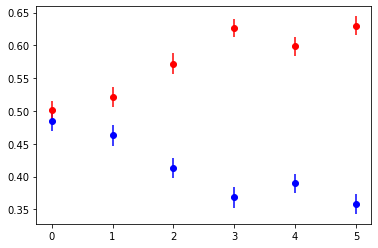

In [ ]:
plt.errorbar(Ts, noisymeans , yerr=noisyerrs, ls='', marker='o', color='b')
plt.errorbar(Ts, mitigatedmeans , yerr=mitigatederrs, ls='', marker='o', color='r')

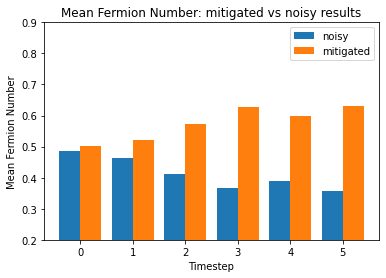

In [ ]:
X = ['0','1','2','3', '4', '5']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, noisymeans, 0.4, label = 'noisy')
plt.bar(X_axis + 0.2, mitigatedmeans, 0.4, label = 'mitigated')

  
plt.xticks(X_axis, X)
plt.xlabel("Timestep")
plt.ylabel("Mean Fermion Number")
plt.title("Mean Fermion Number: mitigated vs noisy results")
plt.ylim([0.2, 0.9])
plt.legend()
plt.show()

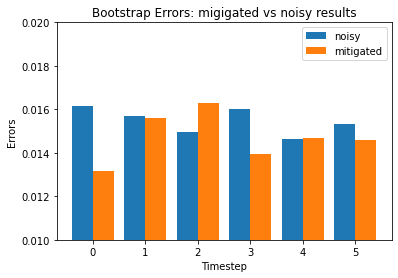

In [ ]:
X = ['0','1','2','3', '4', '5']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, noisyerrs, 0.4, label = 'noisy')
plt.bar(X_axis + 0.2, mitigatederrs, 0.4, label = 'mitigated')

  
plt.xticks(X_axis, X)
plt.xlabel("Timestep")
plt.ylabel("Errors")
plt.title("Bootstrap Errors: migigated vs noisy results")
plt.ylim([0.01, 0.02])
plt.legend()
plt.show()